# Xử lý dữ liệu Địa lý và trực quan hóa 

1. Mục tiêu
- Làm sạch dữ liệu địa lý (`geolocation`), loại bỏ các tọa độ lỗi.
- Vẽ bản đồ phân bố khách hàng để có cái nhìn tổng quan về thị trường.

2. Chuẩn bị thư viện
- Sử dụng các thư viện chính: `pandas` để xử lý dữ liệu, `matplotlib/seaborn` cho biểu đồ tĩnh và `folium` cho bản đồ tương tác.

# 1. Cài đặt và Import thư viện

In [1]:
%%capture
!pip install pandas matplotlib seaborn folium

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


# 2. Đọc và kiểm tra dữ liệu Địa lý

Dữ liệu được lấy từ file `olist_geolocation_dataset.csv`. File này chứa thông tin mã bưu chính (zip code) và tọa độ (kinh độ, vĩ độ) của các khu vực tại Brazil.

In [3]:

df_geo = pd.read_csv('olist_geolocation_dataset.csv') 

print(f"Tổng số dòng dữ liệu ban đầu: {len(df_geo)}")

display(df_geo.head())

print("\nThông tin bộ dữ liệu:")
print(df_geo.info())


Tổng số dòng dữ liệu ban đầu: 1000163


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP



Thông tin bộ dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
None


# 3. Làm sạch dữ liệu (Data Cleaning)

Dữ liệu gốc có kích thước rất lớn (khoảng 1 triệu dòng) do lặp lại nhiều lần cùng một mã bưu chính. Ngoài ra, một số tọa độ bị sai lệch (nằm ngoài lãnh thổ Brazil).

Quy trình xử lý:
1. Loại bỏ trùng lặp: Chỉ giữ lại 1 tọa độ đại diện cho mỗi `geolocation_zip_code_prefix`.
2. Lọc nhiễu (Outliers): Chỉ giữ lại các tọa độ nằm trong biên giới địa lý của Brazil:
   - Vĩ độ (Lat): từ -34 đến 5.5
   - Kinh độ (Lng): từ -74 đến -34

In [4]:

# Bước 1: Loại bỏ trùng lặp để giảm tải dữ liệu
# Giữ lại dòng đầu tiên xuất hiện của mỗi mã Zip
df_geo_clean = df_geo.drop_duplicates(subset=['geolocation_zip_code_prefix'])

print(f"Số dòng sau khi loại bỏ trùng lặp: {len(df_geo_clean):,}")

# Bước 2: Lọc tọa độ nằm trong biên giới Brazil
# Điều kiện lọc:
lat_condition = (df_geo_clean['geolocation_lat'] <= 5.5) & (df_geo_clean['geolocation_lat'] >= -34)
lng_condition = (df_geo_clean['geolocation_lng'] <= -34) & (df_geo_clean['geolocation_lng'] >= -74)

df_brazil = df_geo_clean[lat_condition & lng_condition]

print(f"Số dòng sau khi lọc biên giới: {len(df_brazil):,}")
print(f"-> Đã loại bỏ {len(df_geo_clean) - len(df_brazil)} điểm tọa độ lỗi.")


Số dòng sau khi loại bỏ trùng lặp: 19,015
Số dòng sau khi lọc biên giới: 19,005
-> Đã loại bỏ 10 điểm tọa độ lỗi.


# 4. Trực quan hóa dữ liệu

## 4.1. Biểu đồ phân tán (Scatter Plot)
Biểu đồ tĩnh giúp kiểm tra nhanh hình dạng phân bố của dữ liệu sau khi làm sạch.

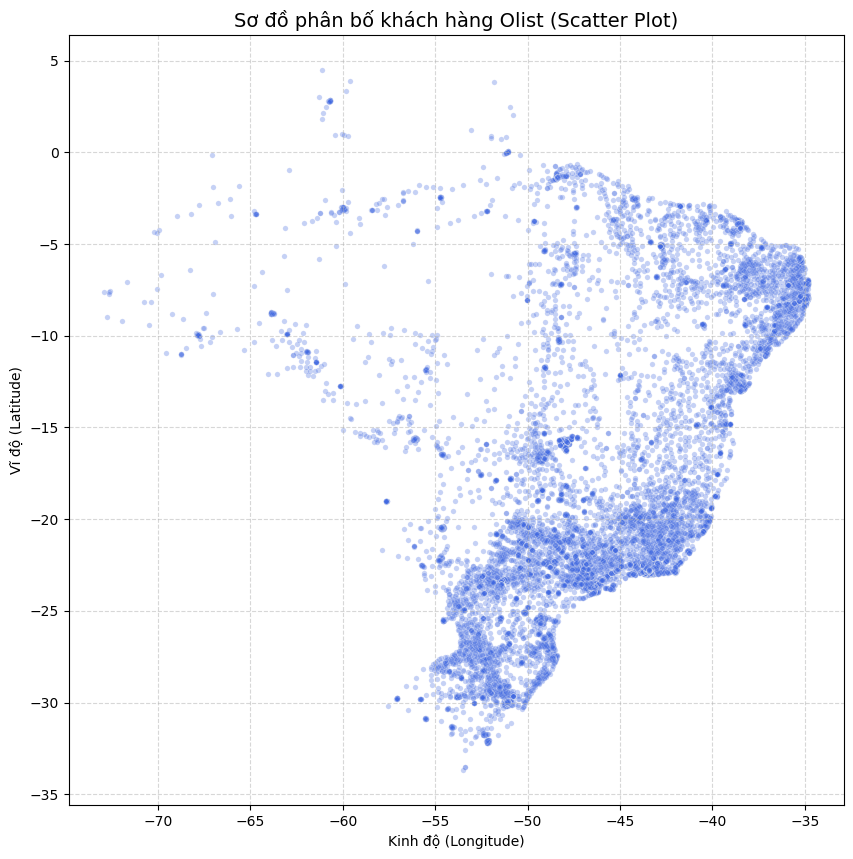

In [5]:

# Vẽ biểu đồ Scatter Plot
plt.figure(figsize=(10, 10))

sns.scatterplot(
    data=df_brazil,
    x='geolocation_lng',
    y='geolocation_lat',
    alpha=0.3, # Độ mờ giúp nhìn rõ vùng mật độ cao
    s=15,      # Kích thước điểm
    color='royalblue'
)

plt.title('Sơ đồ phân bố khách hàng Olist (Scatter Plot)', fontsize=14)
plt.xlabel('Kinh độ (Longitude)')
plt.ylabel('Vĩ độ (Latitude)')
plt.grid(True, linestyle='--', alpha=0.5)

# Lưu ảnh biểu đồ tĩnh 
plt.savefig('brazil_scatter_plot.png')
plt.show()


## 4.2. Bản đồ nhiệt tương tác (Interactive Heatmap)

Sử dụng thư viện `Folium` để tạo bản đồ nhiệt. Vùng màu đỏ thể hiện nơi tập trung nhiều khách hàng nhất.

In [6]:
# Tạo bản đồ nền tập trung vào Brazil
# Tọa độ trung tâm Brazil khoảng: -14.2350, -51.9253
brazil_map = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# Chuẩn bị dữ liệu cho Heatmap (Dạng list: [Lat, Lng])
heat_data = df_brazil[['geolocation_lat', 'geolocation_lng']].values.tolist()

# Thêm lớp Heatmap vào bản đồ
HeatMap(
    heat_data, 
    radius=10, # Bán kính ảnh hưởng của mỗi điểm
    blur=15,   # Độ nhòe
    max_zoom=1,
).add_to(brazil_map)

# Lưu kết quả ra file HTML
output_file = 'brazil_map.html'
brazil_map.save(output_file)

print(f"Đã tạo xong file '{output_file}'")
print("Hãy mở thư mục chứa code này và mở file .html vừa tạo để xem bản đồ.")

# Hiển thị bản đồ
brazil_map

Đã tạo xong file 'brazil_map.html'
Hãy mở thư mục chứa code này và mở file .html vừa tạo để xem bản đồ.
